In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort_by=None, ascending=True, y_func=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None:
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None: 
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else: 
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,385,3,-1.742092,-1.894895,-0.420980,0.647412,1.827927,-1.824537,a,a
1,589,6,2.057625,0.405441,-0.871200,1.977775,-1.223709,0.009313,c,c
2,503,6,-2.041002,0.393238,-1.011221,0.122736,0.418693,1.310588,b,b
3,170,2,-0.184679,0.097730,-1.359450,0.270358,0.674757,-0.596673,a,a
4,934,1,-0.535016,0.810497,-1.155811,1.270026,-1.234818,0.051055,a,a
...,...,...,...,...,...,...,...,...,...,...
9995,389,7,1.032961,-0.839376,-0.864325,1.600410,0.328620,-0.503182,a,a
9996,527,8,0.557386,-0.352096,-0.012018,0.214121,0.347199,0.442943,b,b
9997,350,2,0.370579,1.261406,-1.824409,0.551513,0.555718,0.708058,b,b
9998,653,8,-0.805844,-0.438139,1.699216,0.050666,-0.144075,-0.427047,b,b


In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
5,alice,yellow,7,8,lukewarm
3,rob,red,5,6,hot
2,rob,blue,4,5,hot
11,eve,red,13,14,cold
1,rob,yellow,3,4,hot
6,alice,blue,8,9,lukewarm
9,eve,green,10,11,cold
8,eve,yellow,11,12,cold
7,alice,red,9,10,lukewarm
10,eve,blue,12,12,cold


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
1,rob,yellow,3,4,hot
2,rob,blue,4,5,hot
3,rob,red,5,6,hot
8,eve,yellow,11,12,cold
9,eve,green,10,11,cold
10,eve,blue,12,12,cold
6,alice,blue,8,9,lukewarm
11,eve,red,13,14,cold
5,alice,yellow,7,8,lukewarm
7,alice,red,9,10,lukewarm


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
# export
def add_missing_value_cols(df, cols=None, dtype=float):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

,A,B,missing_A,missing_B
0,NaN,NaN,1.0,1.0
1,-0.255358,0.320305,0.0,0.0
2,-0.565461,-0.135804,0.0,0.0
3,-1.841946,0.716258,0.0,0.0
4,-0.560007,-0.684058,0.0,0.0
5,-1.630563,0.695689,0.0,0.0
6,0.718677,NaN,0.0,1.0
7,NaN,-0.025982,1.0,0.0
8,0.130690,NaN,0.0,1.0
9,-0.566590,0.012924,0.0,0.0


In [ ]:
# export
def add_missing_timestamps(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing timestamps in a dataframe to a desired frequency
    Args:
        df:                      pandas DataFrame
        datetime_col:            column tha contains the datetime data (without duplicates within groups)
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    cols = df.columns
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date, freq=freq)] for min_date, max_date, key in zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(dates, name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    df = df[cols]
    return df

In [ ]:
today = datetime.now()
dates = pd.date_range('2021-05-01', '2021-05-07')
dates2 = np.concatenate([dates[:3], dates[-2:]])
dates3 = pd.date_range(dates2.min(), dates2.max())
test_eq(dates, dates3)
data = np.zeros((len(dates2), 3))
data[:, 0] = dates2
data[:, 1] = np.random.rand(len(dates2))
data[:, 2] = np.array([0, 1, 0, 0, 1])
cols = ['date', 'a', 'b']
date_df = pd.DataFrame(data, columns=cols)
date_df['date'] = pd.to_datetime(date_df['date'])
date_df

,date,a,b
0,2021-05-01,0.940077,0.0
1,2021-05-02,0.817944,1.0
2,2021-05-03,0.449699,0.0
3,2021-05-06,0.694452,0.0
4,2021-05-07,0.199926,1.0


In [ ]:
# Filling dates between min and max dates
add_missing_timestamps(date_df, 'date')

,date,a,b
0,2021-05-01,0.940077,0.0
1,2021-05-02,0.817944,1.0
2,2021-05-03,0.449699,0.0
3,2021-05-04,NaN,NaN
4,2021-05-05,NaN,NaN
5,2021-05-06,0.694452,0.0
6,2021-05-07,0.199926,1.0


In [ ]:
# Filling dates between min and max dates for each value in groupby column
add_missing_timestamps(date_df, 'date', groupby='b')

,date,a,b
0,2021-05-01,0.940077,0.0
1,2021-05-02,NaN,0.0
2,2021-05-03,0.449699,0.0
3,2021-05-04,NaN,0.0
4,2021-05-05,NaN,0.0
5,2021-05-06,0.694452,0.0
6,2021-05-02,0.817944,1.0
7,2021-05-03,NaN,1.0
8,2021-05-04,NaN,1.0
9,2021-05-05,NaN,1.0


In [ ]:
# Filling dates between min and max dataframe dates for all values in groupby column
add_missing_timestamps(date_df, 'date', groupby='b', range_by_group=False)

,date,a,b
0,2021-05-01,0.940077,0.0
1,2021-05-02,NaN,0.0
2,2021-05-03,0.449699,0.0
3,2021-05-04,NaN,0.0
4,2021-05-05,NaN,0.0
5,2021-05-06,0.694452,0.0
6,2021-05-07,NaN,0.0
7,2021-05-01,NaN,1.0
8,2021-05-02,0.817944,1.0
9,2021-05-03,NaN,1.0


In [ ]:
# Filling timestamps between min and max dataframe dates at selected frequency
add_missing_timestamps(date_df, 'date', freq='12H')

,date,a,b
0,2021-05-01 00:00:00,0.940077,0.0
1,2021-05-01 12:00:00,NaN,NaN
2,2021-05-02 00:00:00,0.817944,1.0
3,2021-05-02 12:00:00,NaN,NaN
4,2021-05-03 00:00:00,0.449699,0.0
5,2021-05-03 12:00:00,NaN,NaN
6,2021-05-04 00:00:00,NaN,NaN
7,2021-05-04 12:00:00,NaN,NaN
8,2021-05-05 00:00:00,NaN,NaN
9,2021-05-05 12:00:00,NaN,NaN


In [ ]:
# Filling timestamps between min and max dataframe dates for each value in groupby column at selected frequency
add_missing_timestamps(date_df, 'date', groupby='b', freq='12H')

,date,a,b
0,2021-05-01 00:00:00,0.940077,0.0
1,2021-05-01 12:00:00,NaN,0.0
2,2021-05-02 00:00:00,NaN,0.0
3,2021-05-02 12:00:00,NaN,0.0
4,2021-05-03 00:00:00,0.449699,0.0
5,2021-05-03 12:00:00,NaN,0.0
6,2021-05-04 00:00:00,NaN,0.0
7,2021-05-04 12:00:00,NaN,0.0
8,2021-05-05 00:00:00,NaN,0.0
9,2021-05-05 12:00:00,NaN,0.0


In [ ]:
# Filling timestamps between min and max dataframe dates for all values in groupby column at selected frequency
add_missing_timestamps(date_df, 'date', groupby='b', range_by_group=False, freq='12H')

,date,a,b
0,2021-05-01 00:00:00,0.940077,0.0
1,2021-05-01 12:00:00,NaN,0.0
2,2021-05-02 00:00:00,NaN,0.0
3,2021-05-02 12:00:00,NaN,0.0
4,2021-05-03 00:00:00,0.449699,0.0
5,2021-05-03 12:00:00,NaN,0.0
6,2021-05-04 00:00:00,NaN,0.0
7,2021-05-04 12:00:00,NaN,0.0
8,2021-05-05 00:00:00,NaN,0.0
9,2021-05-05 12:00:00,NaN,0.0


In [ ]:
# export
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    
    Available options: microsecond, millisecond, second, minute, hour, day = day_of_month = dayofmonth, 
    day_of_week = weekday = dayofweek, day_of_year = dayofyear, week = week_of_year = weekofyear, month and year
    """

    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

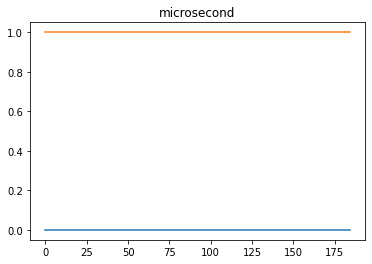

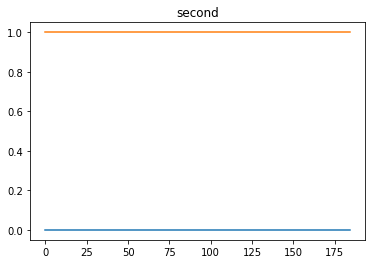

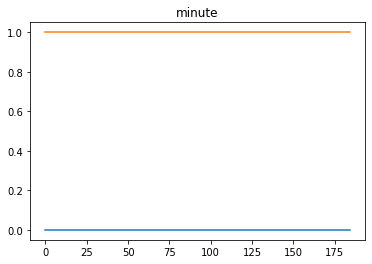

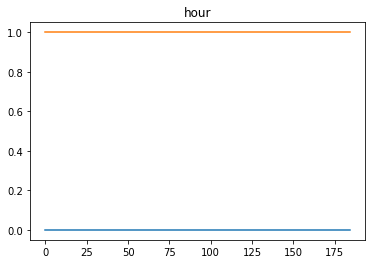

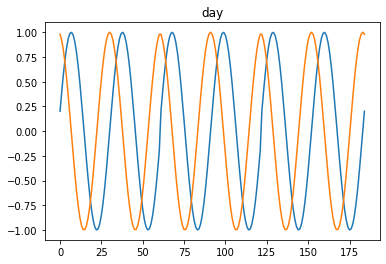

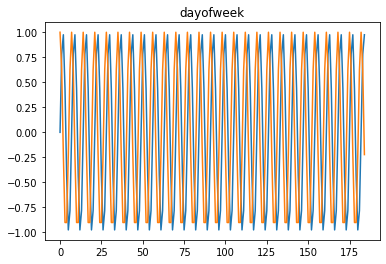

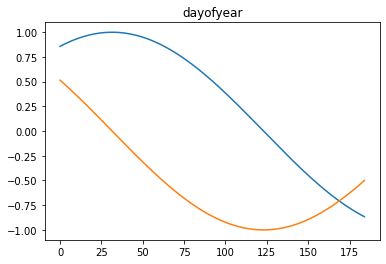

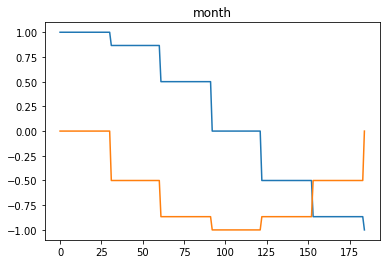

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    tdf = pd.DataFrame(pd.date_range('2021-03-01', datetime.today()), columns=['date'])
    a,b = time_encoding(tdf.date, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

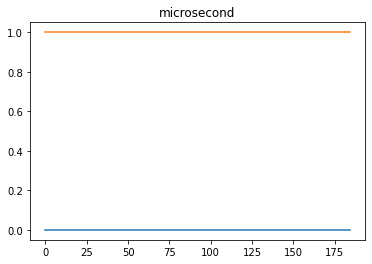

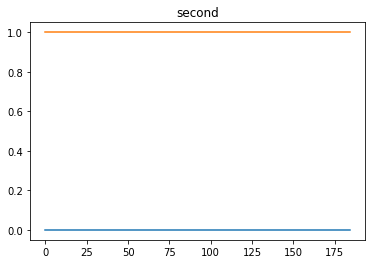

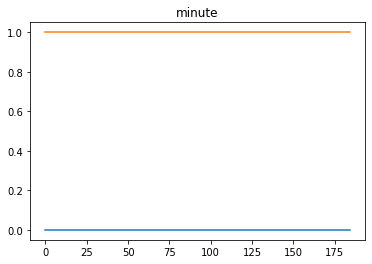

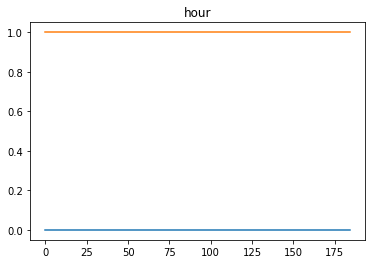

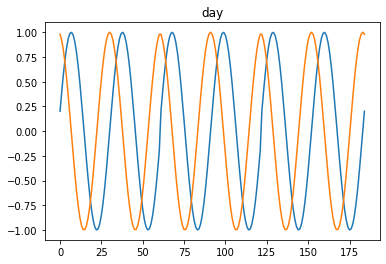

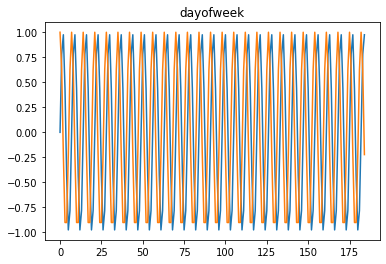

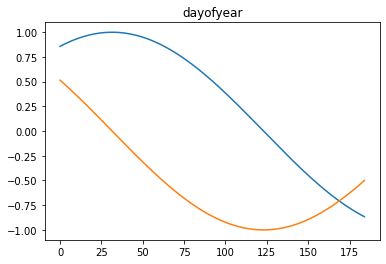

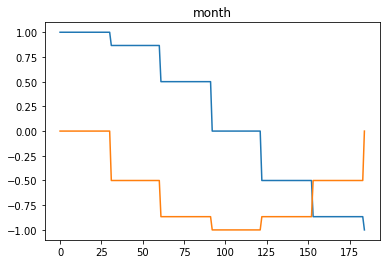

In [ ]:
for freq in ['microsecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'month']:
    dateindex = pd.date_range('2021-03-01', datetime.today())
    a,b = time_encoding(dateindex, freq=freq)
    plt.plot(a)
    plt.plot(b)
    plt.title(freq)
    plt.show()

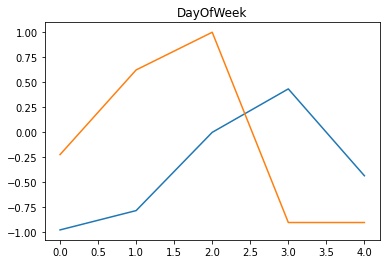

,date,a,b,dow_sin,dow_cos
0,2021-05-01,0.940077,0.0,-0.974928,-0.222521
1,2021-05-02,0.817944,1.0,-0.781831,0.623490
2,2021-05-03,0.449699,0.0,0.000000,1.000000
3,2021-05-06,0.694452,0.0,0.433884,-0.900969
4,2021-05-07,0.199926,1.0,-0.433884,-0.900969


In [ ]:
dow_sin, dow_cos = time_encoding(date_df['date'], 'dayofweek')
plt.plot(dow_sin)
plt.plot(dow_cos)
plt.title('DayOfWeek')
plt.show()
date_df['dow_sin'] = dow_sin
date_df['dow_cos'] = dow_cos
date_df

In [ ]:
# export

def forward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps since previous real value along the last dimension of 3D arrays or tensors"""

    b,c,s=o.shape
    if isinstance(o, torch.Tensor):
        idx = torch.where(o==o, torch.arange(s, device=o.device), 0)
        idx = torch.cummax(idx, axis=-1).values
        gaps = 1 + (torch.arange(s, device=o.device).reshape(1,1,-1).repeat(b, c, 1) - idx).float()
        mask = torch.isnan(o[torch.arange(b, device=o.device)[:,None, None], torch.arange(c, device=o.device)[None, :, None], idx])
    elif isinstance(o, np.ndarray):
        idx = np.where(o==o, np.arange(s), 0)
        idx = np.maximum.accumulate(idx,axis=-1)
        gaps = 1 + (np.arange(s).reshape(1,1,-1).repeat(b, 0).repeat(c, 1) - idx).astype(float)
        mask = np.isnan(o[np.arange(b)[:,None, None], np.arange(c)[None, :, None], idx])
    gaps[mask] = nan_to_num
    if normalize:
        gaps[gaps > 0] = gaps[gaps > 0] / s
    return gaps


def backward_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to next real value along the last dimension of 3D arrays or tensors"""

    if isinstance(o, torch.Tensor): o = torch_flip(o, -1)
    elif isinstance(o, np.ndarray): o = o[..., ::-1]
    gaps = forward_gaps(o, nan_to_num=nan_to_num, normalize=normalize)
    if isinstance(o, torch.Tensor): gaps = torch_flip(gaps, -1)
    elif isinstance(o, np.ndarray): gaps = gaps[..., ::-1]
    return gaps


def nearest_gaps(o, nan_to_num=0, normalize=True):
    """Number of sequence steps to nearest real value along the last dimension of 3D arrays or tensors"""

    forward = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    backward = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
    if isinstance(o, torch.Tensor):
        gaps = torch.fmin(forward, backward)
        gaps[torch.isnan(gaps)] = nan_to_num
        return gaps
    elif isinstance(o, np.ndarray):
        gaps = np.fmin(forward, backward)
        gaps[np.isnan(gaps)] = nan_to_num
        return gaps


def get_gaps(o : Tensor, nan_to_num : int = 0, forward : bool = True, backward : bool = True, 
             nearest : bool = True, normalize : bool = True):
    """Number of sequence steps from previous, to next and/or to nearest real value along the 
    last dimension of 3D arrays or tensors"""
    
    _gaps = []
    if forward or nearest:  
        fwd = forward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if forward: 
            _gaps.append(fwd)
    if backward or nearest: 
        bwd = backward_gaps(o, nan_to_num=np.nan, normalize=normalize)
        if backward: 
            _gaps.append(bwd)
    if nearest:
        if isinstance(o, torch.Tensor): 
            nst = torch.fmin(fwd, bwd)
        elif isinstance(o, np.ndarray): 
            nst = np.fmin(fwd, bwd)
        _gaps.append(nst)
    if isinstance(o, torch.Tensor): 
        gaps = torch.cat(_gaps, 1)
        gaps[torch.isnan(gaps)] = nan_to_num
    elif isinstance(o, np.ndarray):
        gaps = np.concatenate(_gaps, 1)
        gaps[np.isnan(gaps)] = nan_to_num
    return gaps

In [ ]:
t = torch.rand(1, 2, 8)
arr = t.numpy()
t[t <.6] = np.nan
test_ge(nearest_gaps(t).min().item(), 0)
test_ge(nearest_gaps(arr).min(), 0)
test_le(nearest_gaps(t).min().item(), 1)
test_le(nearest_gaps(arr).min(), 1)
test_eq(torch.isnan(forward_gaps(t)).sum(), 0)
test_eq(np.isnan(forward_gaps(arr)).sum(), 0)
ag = get_gaps(t)
test_eq(ag.shape, (1,6,8))
test_eq(torch.isnan(ag).sum(), 0)

In [ ]:
# export

def add_delta_timestamp_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True, nan_to_num=0, normalize=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest:
        if groupby:
            forward_time_gaps = df[cols].groupby(df['user_id']).apply(lambda x: forward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            forward_time_gaps = np.concatenate(forward_time_gaps, -1)[0].transpose(1,0)
        else:
            forward_time_gaps = forward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if forward : 
            df[[f'{col}_dt_fwd' for col in cols]] = forward_time_gaps
            df[[f'{col}_dt_fwd' for col in cols]] = df[[f'{col}_dt_fwd' for col in cols]].fillna(nan_to_num)
    if backward or nearest:
        if groupby:
            backward_time_gaps = df[cols].groupby(df['user_id']).apply(lambda x: backward_gaps(x.values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize))
            backward_time_gaps = np.concatenate(backward_time_gaps, -1)[0].transpose(1,0)
        else:
            backward_time_gaps = backward_gaps(df[cols].values.transpose(1,0)[None], nan_to_num=np.nan, normalize=normalize)[0].transpose(1,0)
        if backward: 
            df[[f'{col}_dt_bwd' for col in cols]] = backward_time_gaps
            df[[f'{col}_dt_bwd' for col in cols]] = df[[f'{col}_dt_bwd' for col in cols]].fillna(nan_to_num)
    if nearest:
        df[[f'{col}_dt_nearest' for col in cols]] = np.fmin(forward_time_gaps, backward_time_gaps)
        df[[f'{col}_dt_nearest' for col in cols]] = df[[f'{col}_dt_nearest' for col in cols]].fillna(nan_to_num)
    return df


In [ ]:
date_df = add_missing_timestamps(date_df, 'date', groupby='b')
add_delta_timestamp_cols(date_df, cols='a')

,date,a,b,dow_sin,dow_cos,a_dt_fwd,a_dt_bwd,a_dt_nearest
0,2021-05-01,0.940077,0.0,-0.974928,-0.222521,0.083333,0.083333,0.083333
1,2021-05-02,NaN,0.0,NaN,NaN,0.166667,0.166667,0.166667
2,2021-05-03,0.449699,0.0,0.000000,1.000000,0.083333,0.083333,0.083333
3,2021-05-04,NaN,0.0,NaN,NaN,0.166667,0.250000,0.166667
4,2021-05-05,NaN,0.0,NaN,NaN,0.250000,0.166667,0.166667
5,2021-05-06,0.694452,0.0,0.433884,-0.900969,0.083333,0.083333,0.083333
6,2021-05-02,0.817944,1.0,-0.781831,0.623490,0.083333,0.083333,0.083333
7,2021-05-03,NaN,1.0,NaN,NaN,0.166667,0.416667,0.166667
8,2021-05-04,NaN,1.0,NaN,NaN,0.250000,0.333333,0.250000
9,2021-05-05,NaN,1.0,NaN,NaN,0.333333,0.250000,0.250000


In [ ]:
# export
# # SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# # https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                  get_x:Union[None, int, list]=None, get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                  horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    Args:
        window_len          = length of lookback window
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y.
                            [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage:
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    if stride == 0 or stride is None:
        stride = window_len

    def _inner(o):
        if copy: 
            if isinstance(o, torch.Tensor):  o = o.clone()
            else: o = o.copy()
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame):
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            if get_y != []: y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            if get_y != []: y = o[:, _get_y]
        seq_len = len(X)
        if get_y != []:
            X_max_time = seq_len - start - window_len - max_horizon - pad_remainder
        else:
            X_max_time = seq_len - start - window_len - pad_remainder
        if pad_remainder:
            if add_padding_feature:
                X = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)
            X_max_time = X_max_time - X_max_time % stride + stride
            if window_len + start + X_max_time - len(X) >= 0:
                _X = np.empty((window_len + start + X_max_time - len(X), *X.shape[1:]))
                _X[:] = padding_value
                if add_padding_feature:
                    _X[:, -1] = 1
                X = np.concatenate((X, _X))
        elif X_max_time < 0: return None, None
        X_sub_windows = (start +
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time + 1, step=stride), 0).T
                        ) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))
        if get_y != [] and y is not None:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon - pad_remainder
            div = 0
            if pad_remainder:
                div = y_max_time % stride
                y_max_time = y_max_time - y_max_time % stride + stride
                if window_len + start + y_max_time - len(y) >= 0:
                    _y = np.empty((window_len + start + y_max_time - len(y), *y.shape[1:]))
                    _y[:] = padding_value
                    y = np.concatenate((y, _y))
            y_sub_windows = (y_start +
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time + div, step=stride), 0).T
                            ) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0:
                y = y_func(y)
            if y.ndim >= 2:
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3:
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X

input shape: (13, 3)


array([[[ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  1.,  2.,  3.,  4.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 5.,  6.,  7.,  8.,  9.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [10., 11., 12., nan, nan],
        [ 0.,  0.,  0.,  1.,  1.]]])

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


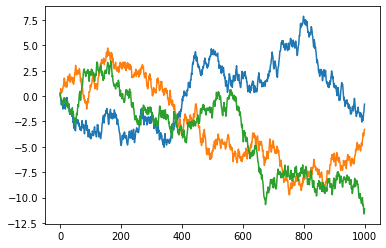

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.241246,-0.106386,-0.047891
1,0.077222,-0.539736,-0.020077
2,-0.416915,-0.961359,0.174147
3,-0.298378,-0.708049,0.372464
4,-0.339152,-0.567024,0.788066
...,...,...,...
95,-0.643641,-0.802253,-1.721232
96,-0.752889,-0.326488,-1.359507
97,-0.435192,-0.102093,-1.802742
98,-0.564356,-0.233533,-1.345820


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.486193,0.003579,0.409439,-0.045260,-0.383753
1,0.493863,-0.303410,0.509579,-0.152497,-0.658385
2,0.057572,-0.323702,0.958028,-0.310118,-0.523026
3,0.158490,-0.060505,1.109902,-0.435412,-0.671930
4,0.656943,-0.198052,0.647082,-0.684221,-0.968542
...,...,...,...,...,...
95,-1.701388,1.461164,-2.262043,-1.845841,2.268388
96,-1.944186,1.510975,-2.336784,-1.738477,2.102854
97,-1.924308,1.607441,-2.789745,-1.942592,2.352324
98,-2.060389,1.528205,-3.099612,-1.701500,2.221828


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.486348,-0.000312,0.056267,-0.325049,-0.166559,-0.467914,-0.325247,-0.644939,-0.825954,-0.857317,...,3.046400,3.056998,2.869515,2.808047,3.044440,2.843424,2.387485,2.033998,2.261500,2.738515
var_1,0.256069,0.271505,0.570474,0.276935,0.290833,-0.058230,-0.202268,-0.540281,-0.932453,-1.076059,...,1.054887,0.784570,1.153435,1.041443,1.129336,0.672450,0.710775,0.817372,1.091040,1.030713
var_2,0.039496,0.401396,0.570844,0.516632,0.243703,0.122683,0.514490,0.868493,0.591632,0.371173,...,-2.256993,-2.682177,-2.932166,-3.096901,-2.747388,-2.693903,-2.217312,-1.873985,-1.435870,-0.990230
var_3,0.218280,0.118842,0.162699,-0.075384,-0.068463,0.275398,0.614544,0.957710,1.142099,1.065763,...,1.463486,1.264479,1.649443,1.460103,1.394636,1.597510,1.917357,2.051891,1.952748,2.035318
target,-0.087091,0.179456,-0.057255,0.155428,-0.309666,-0.344782,-0.441161,-0.111367,0.250178,0.118674,...,0.612225,1.071380,1.567709,1.099139,0.977689,1.172821,1.528685,1.978517,1.816901,2.020741


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.267285,0.002341,0.406788,0.882273,0.393176,0.769510,0.336063,0.113041,-0.293003,-0.001116,...,-0.861665,-1.196842,-0.850829,-1.233039,-1.396577,-1.459291,-1.652866,-1.523599,-1.332310,-1.258353
var_1,0.304780,0.122685,-0.108108,-0.263964,-0.097566,-0.302792,-0.199255,0.089729,-0.074943,-0.164781,...,1.950902,2.101879,2.497760,2.197671,1.751497,1.969235,1.623295,1.475724,1.361802,1.392230
var_2,-0.271899,-0.707676,-1.052057,-0.576377,-0.993567,-1.226440,-1.027263,-0.888943,-1.041031,-0.703726,...,1.449973,1.426564,1.186352,1.332585,1.003061,1.010595,0.615581,0.986391,0.874198,0.720734
var_3,-0.259954,-0.115386,0.132748,0.249621,0.320571,0.753998,0.728789,0.545370,0.890597,0.658194,...,1.098685,1.281451,1.313837,1.060360,1.185294,0.981204,0.949823,0.797408,1.213636,0.980021
target,-0.064539,0.351856,0.405011,0.274978,-0.179062,-0.440180,0.013031,-0.074912,0.128762,0.003134,...,1.560725,1.146076,1.367428,1.156107,1.418399,1.576153,1.369755,1.266868,0.803082,0.361912


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.234671,0.049508,0.212234,0.478143,-0.388824
1,0.596141,-0.430209,0.050441,0.918936,-0.353047
2,0.904967,-0.028525,0.007965,1.408024,0.136942
3,1.253291,0.341189,0.495032,1.870665,-0.338666
4,1.270711,0.753555,0.154981,1.647869,0.134233
...,...,...,...,...,...
95,-0.673341,-4.938320,2.393673,0.284077,0.802540
96,-0.715418,-4.550089,1.952882,0.763170,1.047116
97,-0.587542,-4.429364,1.674009,0.787632,0.929018
98,-0.797357,-4.455724,1.992775,1.009206,0.978835


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
data = np.concatenate([np.linspace(0, 1, 11).reshape(-1,1).repeat(2, 1), np.arange(11).reshape(-1,1)], -1)
df_test = pd.DataFrame(data, columns=['col1', 'col2', 'target'])
df_test['target'] = df_test['target'].astype(int)
df_test

,col1,col2,target
0,0.0,0.0,0
1,0.1,0.1,1
2,0.2,0.2,2
3,0.3,0.3,3
4,0.4,0.4,4
5,0.5,0.5,5
6,0.6,0.6,6
7,0.7,0.7,7
8,0.8,0.8,8
9,0.9,0.9,9


In [ ]:
def _y_func(o): return o[:, 0]

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=_y_func)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)
    test_close(x[:, 0, 0]*10, y)

In [ ]:
for wl in np.arange(1, 20):
    x, y = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/ wl))
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, len(df_test)+1):
    x, y = SlidingWindow(wl, None, pad_remainder=False, get_x=['col1', 'col2'], get_y=['target'], horizon=-wl, y_func=None)(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[0], y.shape[0])
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(1, 20):
    x, _ = SlidingWindow(wl, None, pad_remainder=True, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], math.ceil((len(df_test))/wl))
    test_eq(x.shape[1], 3)
    test_eq(x.shape[2], wl)

In [ ]:
for wl in np.arange(2, len(df_test)):
    x, _ = SlidingWindow(wl, wl, pad_remainder=False, get_x=['col1', 'col2'], get_y=[])(df_test)
    test_eq(x.shape[0], len(df_test) // wl)
    test_eq(x.shape[1], 2)
    test_eq(x.shape[2], wl)

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0,
                       pad_remainder:bool=False, padding_value:float=np.nan, add_padding_feature:bool=True,
                       get_x:Union[None, int, list]=None,  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, copy:bool=False,
                       horizon:Union[int, list]=1, seq_first:bool=True, sort_by:Optional[list]=None, ascending:bool=True,
                       check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.

    Args:
        window_len          = length of lookback window
        unique_id_cols      = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride              = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start               = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None).
        pad_remainder       = allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
        padding_value       = value (float) that will be used for padding. Default: np.nan
        add_padding_feature = add an additional feature indicating whether each timestep is padded (1) or not (0).
        horizon             = number of future datapoints to predict:
                            * 0 for last step in each sub-window.
                            * n > 0 for a range of n future steps (1 to n).
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x               = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y               = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func              = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        copy                = copy the original object to avoid changes in it.
        seq_first           = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by             = column/s used for sorting the array in ascending order
        ascending           = used in sorting
        check_leakage       = checks if there's leakage in the output between X and y
        return_key          = when True, the key corresponsing to unique_id_cols for each sample is returned
        verbose             = controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.


    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None and not  is_listy(sort_by): sort_by = [sort_by]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])

    def _SlidingWindowPanel(o):

        if copy: 
            o = o.copy()
        o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = o[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, pad_remainder=pad_remainder, padding_value=padding_value,
                                     add_padding_feature=add_padding_feature, get_x=get_x, get_y=get_y, y_func=y_func,
                                     horizon=horizon, seq_first=seq_first,
                                     check_leakage=check_leakage)(o[(o[unique_id_cols].values == v).sum(axis=1) == len(v)])
            if x_v is not None and len(x_v) > 0:
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            elif verbose>=2:
                print(f'cannot use {unique_id_cols} = {v} due to not having enough records')

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key:
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y

    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,47058,470580,4705800,47058000,470580000,4705800000,47058000000,470580000000,4705800000000,47058000000000,47058,0,1,A,47058
1,30005,300050,3000500,30005000,300050000,3000500000,30005000000,300050000000,3000500000000,30005000000000,30005,0,1,A,30005
2,81235,812350,8123500,81235000,812350000,8123500000,81235000000,812350000000,8123500000000,81235000000000,81235,0,0,A,81235
3,13946,139442,1394402,13944000,139440000,1394400000,13944000000,139440000000,1394400000000,13944000000000,13944,2,2,B,113948
4,36873,368730,3687300,36873000,368730000,3687300000,36873000000,368730000000,3687300000000,36873000000000,36873,0,1,A,36873


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

((199982, 10, 5), (199982,))

In [ ]:
# export

def identify_padding(float_mask, value=-1):
    """Identifies padded subsequences in a mask of type float
    
    This function identifies as padded subsequences those where all values == nan 
    from the end of the sequence (last dimension) across all channels, and sets
    those values to the selected value (default = -1)
    
    Args:
        mask: boolean or float mask
        value: scalar that will be used to identify padded subsequences 
    """
    padding = torch.argmax((torch.flip(float_mask.mean((1)) - 1, (-1,)) != 0).float(), -1)
    padded_idxs = torch.arange(len(float_mask))[padding != 0]
    if len(padded_idxs) > 0:
        padding = padding[padding != 0]
        for idx,pad in zip(padded_idxs, padding): float_mask[idx, :, -pad:] = value
    return float_mask

In [ ]:
wl = 5
stride = 5

t = np.repeat(np.arange(13).reshape(-1,1), 3, axis=-1)
print('input shape:', t.shape)
X, _ = SlidingWindow(wl, stride=stride, pad_remainder=True, get_y=[])(t)
X = tensor(X)
X[0, 1, -2:] = np.nan
X[1,..., :3] = np.nan
print(X)
identify_padding(torch.isnan(X).float())

input shape: (13, 3)
tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  1.,  2., nan, nan],
         [ 0.,  1.,  2.,  3.,  4.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  8.,  9.],
         [nan, nan, nan,  0.,  0.]],

        [[10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [10., 11., 12., nan, nan],
         [ 0.,  0.,  0.,  1.,  1.]]])


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.